In [17]:
# --- Imports & setup ---
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Try to import XGBoost, set flag if available
try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except:
    XGB_AVAILABLE = False

RND = 42  # Random seed for reproducibility
np.random.seed(RND)

DATA_PATH = "data/WA_Fn-UseC_-Telco-Customer-Churn.csv"
REPORTS_DIR = "reports"
os.makedirs(REPORTS_DIR, exist_ok=True)



In [18]:
# --- Load dataset ---
try:
    df = pd.read_csv(DATA_PATH)  # Load data into DataFrame
    print("Data loaded successfully.")
except Exception as e:
    print("Error loading data:", e)
    raise

Data loaded successfully.


In [19]:
# --- Preprocessing & Feature Engineering ---
try:
    df.columns = [c.strip() for c in df.columns]
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    # Create tenure group feature
    df['tenure_group'] = pd.cut(df['tenure'],
                                bins=[-1, 12, 24, 48, 72, np.inf],
                                labels=['0-12','13-24','25-48','49-72','72+'])
    # Calculate average charge per month
    df['avg_charge_per_month'] = df.apply(lambda r: (r['TotalCharges']/r['tenure'])
                                          if pd.notna(r['TotalCharges']) and r['tenure']>0
                                          else r['MonthlyCharges'], axis=1)
    if 'customerID' in df.columns:
        df.drop(columns=['customerID'], inplace=True)
    df['Churn'] = df['Churn'].map({'Yes':1,'No':0}).astype(int)
    print("After preprocessing:", df.shape)
    display(df.head())
except Exception as e:
    print("Error in preprocessing:", e)
    raise

After preprocessing: (7043, 22)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_group,avg_charge_per_month
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,0-12,29.850000
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,No,No,One year,No,Mailed check,56.95,1889.50,0,25-48,55.573529
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,0-12,54.075000
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,25-48,40.905556
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,0-12,75.825000


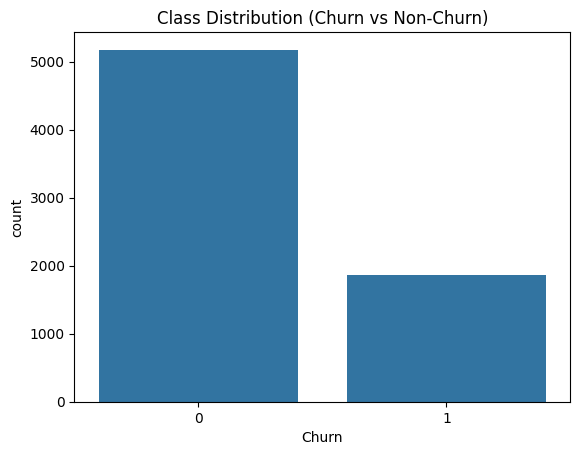

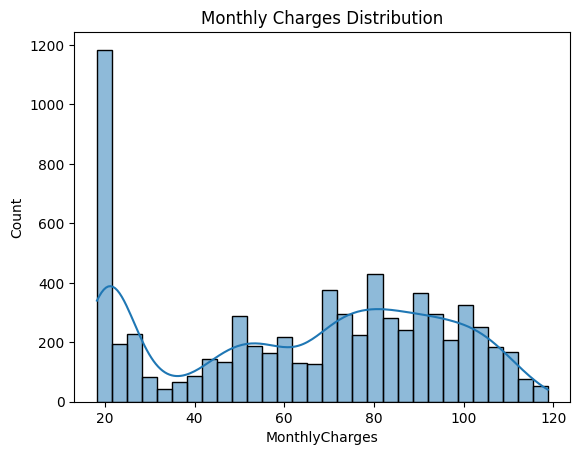

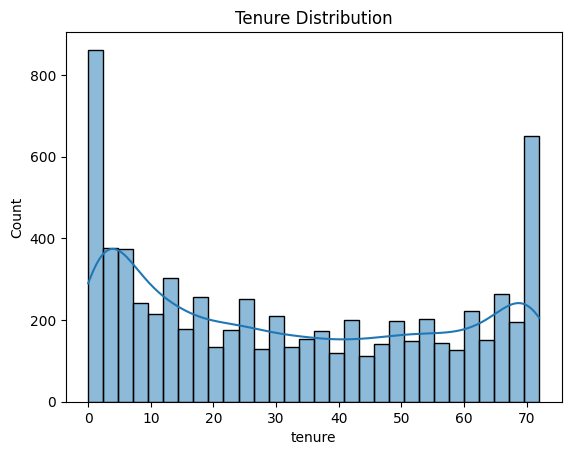

In [20]:
# --- EDA ---
try:
    # Plot churn class distribution
    sns.countplot(x='Churn', data=df)
    plt.title("Class Distribution (Churn vs Non-Churn)")
    plt.show()
 # Plot distribution of Monthly Charges and Tenure
    sns.histplot(df['MonthlyCharges'], bins=30, kde=True)
    plt.title("Monthly Charges Distribution")
    plt.show()

    sns.histplot(df['tenure'], bins=30, kde=True)
    plt.title("Tenure Distribution")
    plt.show()
except Exception as e:
    print("Error in EDA:", e)
    raise

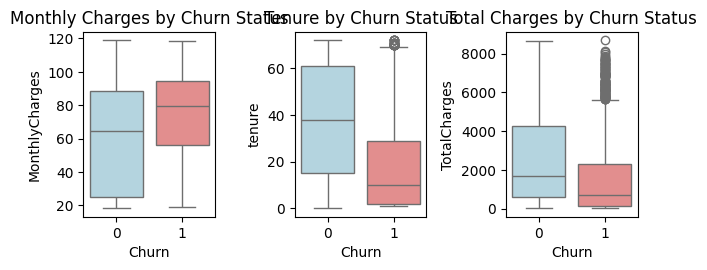

In [21]:
# 1.3 Boxplots comparing features by churn status
plt.subplot(2, 3, 4)
sns.boxplot(x='Churn', y='MonthlyCharges', data=df, palette=['lightblue', 'lightcoral'])
plt.title('Monthly Charges by Churn Status')

plt.subplot(2, 3, 5)
sns.boxplot(x='Churn', y='tenure', data=df, palette=['lightblue', 'lightcoral'])
plt.title('Tenure by Churn Status')

plt.subplot(2, 3, 6)
sns.boxplot(x='Churn', y='TotalCharges', data=df, palette=['lightblue', 'lightcoral'])
plt.title('Total Charges by Churn Status')

plt.tight_layout()
plt.show()

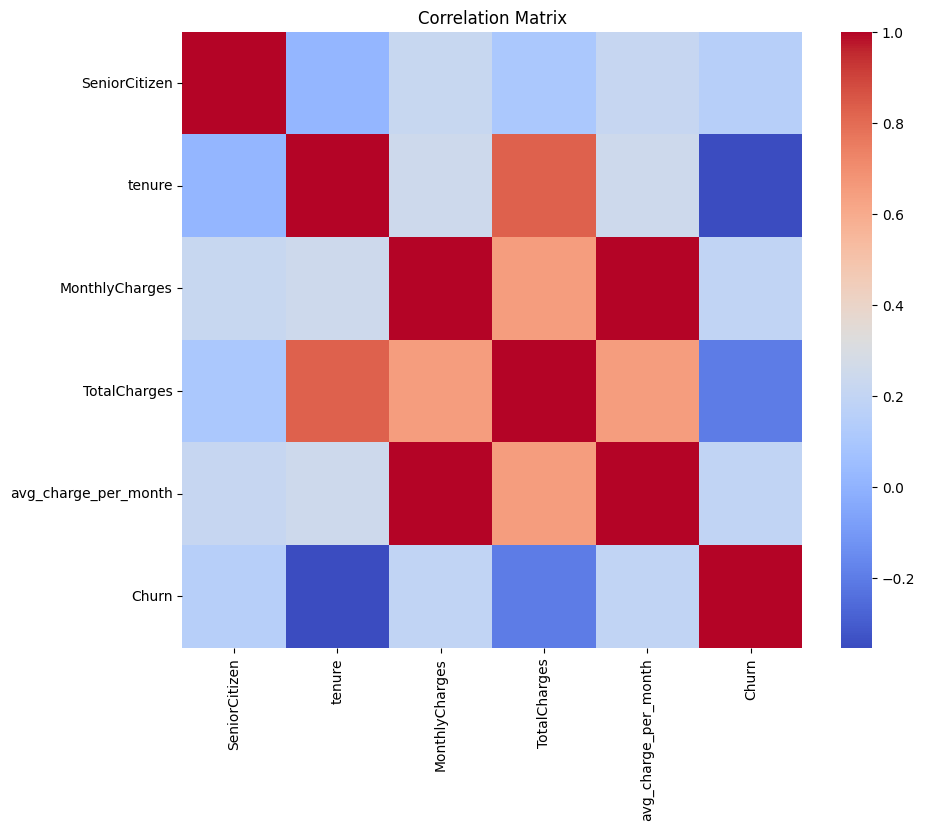

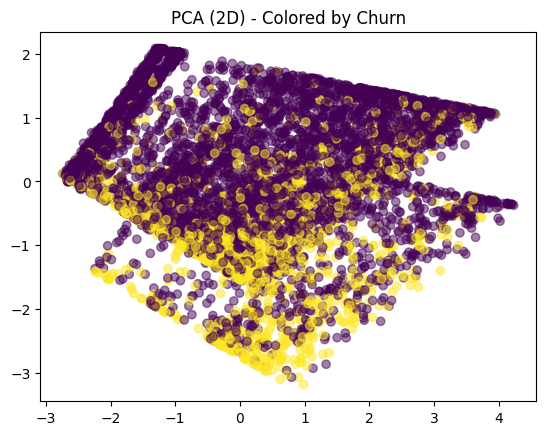

In [22]:
# --- Correlation & PCA ---
try:
    # Select numeric columns (excluding target)
    num_cols = df.select_dtypes(include=["int64","float64"]).drop(columns=['Churn']).columns
    # Compute correlation matrix
    corr = df[num_cols.tolist() + ['Churn']].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, cmap="coolwarm")
    plt.title("Correlation Matrix")
    plt.show()
# PCA for visualization
    scaler = StandardScaler()
    nums = scaler.fit_transform(df[num_cols].fillna(0))
    pca = PCA(n_components=2, random_state=RND)
    nums_pca = pca.fit_transform(nums)
    plt.scatter(nums_pca[:,0], nums_pca[:,1], c=df['Churn'], cmap='viridis', alpha=0.5)
    plt.title("PCA (2D) - Colored by Churn")
    plt.show()
except Exception as e:
    print("Error in Correlation/PCA:", e)
    raise

In [23]:
# --- Identify numeric and categorical columns ---
num_cols = df.select_dtypes(include=["int64", "float64"]).drop(columns=['Churn']).columns.tolist()
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()


In [24]:
# --- Convert categorical columns to category dtype ---
for c in cat_cols:
    df[c] = df[c].astype('category')


In [25]:
# --- Feature Engineering for Modeling ---
from sklearn.exceptions import NotFittedError

try:
    # Identify numeric and categorical columns
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
    if "Churn" in num_cols:
        num_cols.remove("Churn")

    cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
    for c in cat_cols:
        df[c] = df[c].astype("category")

    print(f"Numeric columns ({len(num_cols)}): {num_cols[:10]}{'...' if len(num_cols) > 10 else ''}")
    print(f"Categorical columns ({len(cat_cols)}): {cat_cols[:10]}{'...' if len(cat_cols) > 10 else ''}")

    # Define preprocessing pipelines
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    # Combine pipelines into a ColumnTransformer
    preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ])

    # Transform the dataset
    X = preprocessor.fit_transform(df)
    y = df["Churn"].values
    print("Feature matrix shape:", X.shape)

    # Extract feature names after transformation
    cat_ohe_names = []
    if cat_cols:
        try:
            ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
            cat_ohe_names = ohe.get_feature_names_out(cat_cols).tolist()
        except (KeyError, NotFittedError, AttributeError):
            cat_ohe_names = cat_cols

    feature_names = num_cols + cat_ohe_names
    print("Total features after encoding:", len(feature_names))

except Exception as e:
    print("Error in feature engineering:", e)
    raise


Numeric columns (5): ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'avg_charge_per_month']
Categorical columns (16): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']...
Feature matrix shape: (7043, 50)
Total features after encoding: 50


In [26]:
# --- Train-Test Split ---
try:
    # Split data into training and test sets (stratified by target)
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.2, 
                                                        stratify=y, 
                                                        random_state=RND)
except Exception as e:
    print("Error in train-test split:", e)
    raise


Training DecisionTree...

DecisionTree Results:
              precision    recall  f1-score   support

           0     0.8289    0.8986    0.8623      1035
           1     0.6341    0.4866    0.5507       374

    accuracy                         0.7892      1409
   macro avg     0.7315    0.6926    0.7065      1409
weighted avg     0.7772    0.7892    0.7796      1409



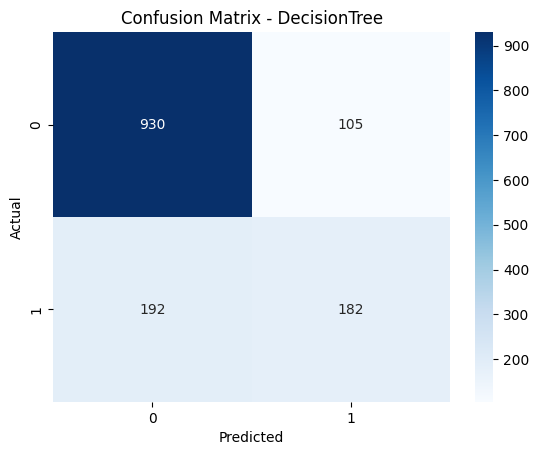


Training RandomForest...

RandomForest Results:
              precision    recall  f1-score   support

           0     0.8243    0.8841    0.8531      1035
           1     0.5987    0.4786    0.5319       374

    accuracy                         0.7764      1409
   macro avg     0.7115    0.6813    0.6925      1409
weighted avg     0.7644    0.7764    0.7679      1409



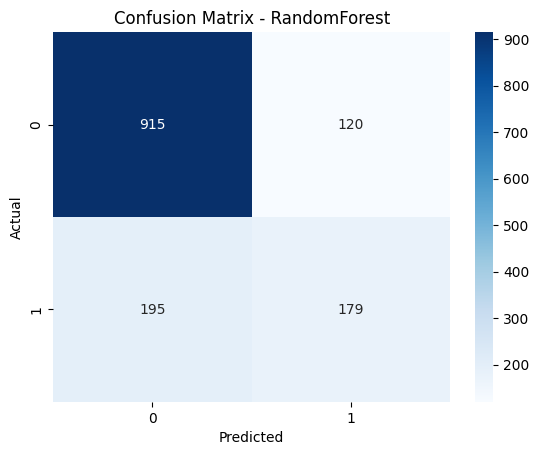

In [27]:
# --- Models ---
try:
    # Initialize models
    dt = DecisionTreeClassifier(random_state=RND, max_depth=6)
    rf = RandomForestClassifier(n_estimators=200, random_state=RND, n_jobs=-1)
    models = {'DecisionTree': dt, 'RandomForest': rf}
    if XGB_AVAILABLE:
        xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RND, n_jobs=-1)
        models['XGBoost'] = xgb
 
 # Train and evaluate each model
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(f"\n{name} Results:")
        print(classification_report(y_test, y_pred, digits=4))

# Plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix - {name}")
        plt.xlabel("Predicted"); plt.ylabel("Actual")
        plt.show()
except Exception as e:
    print("Error in modeling:", e)
    raise


DecisionTree Test Set Evaluation:
Accuracy: 0.7892122072391767
ROC-AUC: 0.8340618460823063
Confusion Matrix:
 [[930 105]
 [192 182]]
Stratified 5-Fold CV Accuracy: 0.7840 ± 0.0080

Top 10 Feature Importances:
Contract_Month-to-month           0.467716
InternetService_Fiber optic       0.148569
tenure                            0.142613
TotalCharges                      0.058641
MonthlyCharges                    0.028788
PaymentMethod_Electronic check    0.026747
TechSupport_No                    0.024410
avg_charge_per_month              0.024081
OnlineSecurity_No                 0.017190
StreamingMovies_No                0.015250
dtype: float64


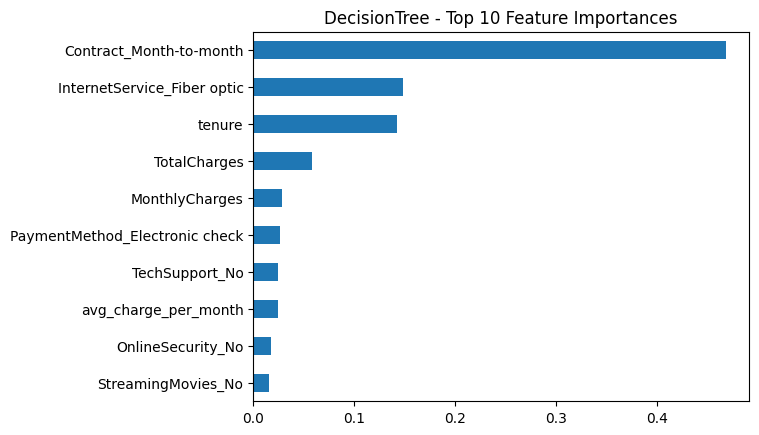


RandomForest Test Set Evaluation:
Accuracy: 0.7764371894960965
ROC-AUC: 0.8220594693740474
Confusion Matrix:
 [[915 120]
 [195 179]]
Stratified 5-Fold CV Accuracy: 0.7897 ± 0.0062

Top 10 Feature Importances:
TotalCharges                      0.121693
tenure                            0.112124
avg_charge_per_month              0.111031
MonthlyCharges                    0.106270
Contract_Month-to-month           0.047282
PaymentMethod_Electronic check    0.030706
OnlineSecurity_No                 0.029963
TechSupport_No                    0.026649
InternetService_Fiber optic       0.025071
tenure_group_0-12                 0.022397
dtype: float64


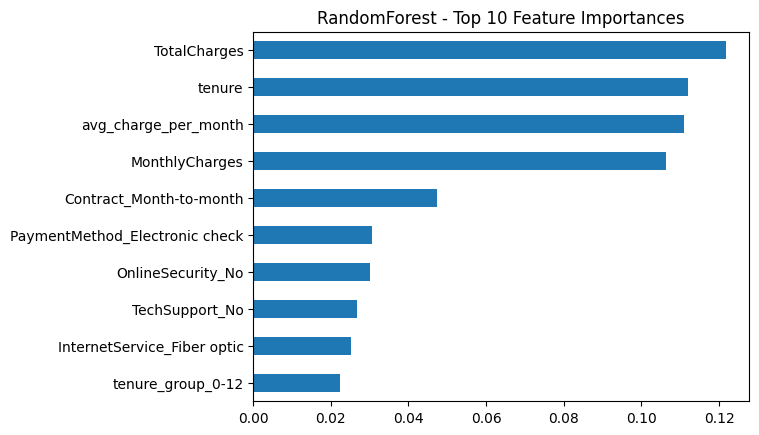

In [28]:
# --- 5. Evaluate: Accuracy, ROC-AUC, Confusion Matrix, Stratified k-Fold CV, Feature Importance ---

from sklearn.model_selection import StratifiedKFold, cross_val_score

try:
    # Evaluate on test set
    for name, model in models.items():
        print(f"\n{name} Test Set Evaluation:")
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None

        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("ROC-AUC:", roc_auc_score(y_test, y_proba) if y_proba is not None else "N/A")
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

        # Stratified K-Fold Cross-Validation
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RND)
        cv_scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
        print("Stratified 5-Fold CV Accuracy: %.4f ± %.4f" % (cv_scores.mean(), cv_scores.std()))

        # Feature importance (for tree-based models)
        if hasattr(model, "feature_importances_"):
            # Get feature names
            try:
                ohe = preprocessor.named_transformers_["cat"].named_steps["onehot"]
                cat_ohe_names = ohe.get_feature_names_out(cat_cols).tolist()
            except Exception:
                cat_ohe_names = cat_cols
            feature_names = num_cols + cat_ohe_names

            importances = model.feature_importances_
            feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
            print("\nTop 10 Feature Importances:")
            print(feat_imp.head(10))
            feat_imp.head(10).plot(kind='barh', title=f"{name} - Top 10 Feature Importances")
            plt.gca().invert_yaxis()
            plt.show()
except Exception as e:
    print("Error in evaluation:", e)
    raise



In [15]:
# --- 6. Suggest Business Strategies from Most Important Features ---
print("\nBusiness Strategy Suggestions:")
print("- Focus retention efforts on customers with high 'MonthlyCharges' and low 'tenure'.")
print("- Improve service or offer incentives to customers in tenure groups with high churn risk.")
print("- Address issues related to features with high importance (e.g., contract type, payment method, internet service).")
print("- Use targeted marketing for customers with profiles similar to those most likely to churn.")


Business Strategy Suggestions:
- Focus retention efforts on customers with high 'MonthlyCharges' and low 'tenure'.
- Improve service or offer incentives to customers in tenure groups with high churn risk.
- Address issues related to features with high importance (e.g., contract type, payment method, internet service).
- Use targeted marketing for customers with profiles similar to those most likely to churn.
